In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/dl-sp-c1w4/datasets'

def load_data():
    import h5py
    import numpy as np
    import os

    train_path = f"{DATA_DIR}/train_catvnoncat.h5"
    test_path = f"{DATA_DIR}/test_catvnoncat.h5"

    train_dataset = h5py.File(train_path, "r")
    train_set_x_orig = torch.from_numpy(np.array(train_dataset["train_set_x"][:])).float()
    train_set_x = train_set_x_orig.view(train_set_x_orig.shape[0], -1)
    train_set_y = torch.from_numpy(np.array(train_dataset["train_set_y"][:])).float()

    test_dataset = h5py.File(test_path, "r")
    test_set_x_orig = torch.from_numpy(np.array(test_dataset["test_set_x"][:])).float()
    test_set_x = test_set_x_orig.view(test_set_x_orig.shape[0], -1)
    test_set_y = torch.from_numpy(np.array(test_dataset["test_set_y"][:])).float()

    classes = test_dataset["list_classes"][:]
    classes = [x.decode('utf-8') for x in classes]

    return train_set_x, train_set_y, test_set_x, test_set_y, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
train_x_orig.shape, train_y.shape, test_x_orig.shape, test_y.shape

(torch.Size([209, 12288]),
 torch.Size([209]),
 torch.Size([50, 12288]),
 torch.Size([50]))

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out)

  def __call__(self, x):
    self.out = x @ self.weight + self.bias
    if self.out.shape[1] == 1:
      self.out = self.out.squeeze(1)
    return self.out

  def parameters(self):
    return [self.weight, self.bias]


class LeakyRelu:

  def __init__(self):
    self.relu = torch.nn.LeakyReLU()

  def __call__(self, x):
    self.out = self.relu(x)
    return self.out

  def parameters(self):
    return []

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self._parameters = [self.gamma, self.beta]

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return self._parameters

class LinearStack:

  def __init__(self, fan_in:int, layer_dims:list[int]):
    layers = [Linear(fan_in, layer_dims[0]), BatchNorm1d(layer_dims[0]), LeakyRelu()]
    for i in range(1, len(layer_dims)):
      layer_fan_in, layer_fan_out = layer_dims[i-1], layer_dims[i]
      layers.append(Linear(layer_fan_in, layer_fan_out))

      # Try commenting this line out and see the mindf*** which happens
      # I literally had to go and see the distribution of `out` of each layer to understand what could be going wrong
      layers.append(BatchNorm1d(layer_fan_out))

      layers.append(LeakyRelu())
    self.layers = layers
    self._parameters = [p for layer in layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters


class Sigmoid:

  def __call__(self, x):
    self.out = torch.sigmoid(x)
    return self.out

  def parameters(self):
    return []


class Sequential:

  def __init__(self, layers):
    self.layers = []
    for layer in layers:
        if hasattr(layer, 'layers'):
            self.layers.extend(layer.layers)
        else:
            self.layers.append(layer)
    self._parameters = [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters

  def print_outs(self):
    for layer in self.layers:
        print(layer.__class__.__name__)
        print(layer.out)

In [ ]:
def L_layer_model(layers_dims):
    model = Sequential([
        LinearStack(train_x_orig.shape[1], layers_dims),
        Linear(layers_dims[-1], 1), Sigmoid(),
        ])

    # parameter init
    with torch.no_grad():
        model.layers[-2].weight *= 0.1 # last layer make less confident

    parameters = model.parameters()

    for p in parameters:
        p.requires_grad = True

    return model, sum(p.nelement() for p in parameters)

In [ ]:
# model, nparameters = L_layer_model([5])
# print(f"{nparameters=}")

# losses = []
# loss = torch.nn.BCELoss()

In [ ]:
# X, Y = train_x_orig, train_y
# learning_rate = 0.001

# # Batch data preparation
# batch_x, batch_y = X, Y

# # Forward propagation:
# batch_y_pred = model(batch_x)
# lossi = loss(batch_y_pred, batch_y)

# losses.append(lossi.item())
# lossi

In [ ]:
# lyr = model.layers[5]
# print(lyr.__class__.__name__)
# data = lyr.out.detach().flatten()
# plt.hist(data)

In [ ]:
# # backward pass
# for p in model.parameters():
#     p.grad = None
# lossi.backward()
# model.grads()

In [ ]:
# # update: simple SGD
# for p in model.parameters():
#     p.data += -learning_rate * p.grad
# model.parameters()

In [ ]:
layers_dims = [6, 5, 4]

model, nparameters = L_layer_model(layers_dims)
print(f"{nparameters=}")

def train(model, X, Y, learning_rate = 0.05, num_iterations = 2000):

    for layer in model.layers:
        layer.training = True

    losses = []
    loss = torch.nn.BCELoss()

    for i in range(0, num_iterations):

        # Batch data preparation
        batch_x, batch_y = X, Y

        # Forward propagation:
        batch_y_pred = model(batch_x)
        lossi = loss(batch_y_pred, batch_y)

        # backward pass
        for p in model.parameters():
            p.grad = None
        lossi.backward()

        # update: simple SGD
        for p in model.parameters():
            p.data += -(learning_rate * (1 - (i > (0.85*num_iterations)) * 0.9)) * p.grad

        if (i % 100 == 0) or (i == num_iterations - 1):
            print(f"Iteration {i+1} | Loss: {lossi.item()}")

        losses.append(lossi.item())

    return losses

losses = train(model, train_x_orig, train_y)

nparameters=73828
Iteration 1 | Loss: 0.6784414052963257
Iteration 101 | Loss: 0.41277292370796204
Iteration 201 | Loss: 0.20921973884105682
Iteration 301 | Loss: 0.14297592639923096
Iteration 401 | Loss: 0.10691392421722412
Iteration 501 | Loss: 0.08529554307460785
Iteration 601 | Loss: 0.0713895857334137
Iteration 701 | Loss: 0.06189650297164917
Iteration 801 | Loss: 0.0590977743268013
Iteration 901 | Loss: 0.0399126261472702
Iteration 1001 | Loss: 0.034577298909425735
Iteration 1101 | Loss: 0.030494626611471176
Iteration 1201 | Loss: 0.027249591425061226
Iteration 1301 | Loss: 0.02459944784641266
Iteration 1401 | Loss: 0.022410858422517776
Iteration 1501 | Loss: 0.020570870488882065
Iteration 1601 | Loss: 0.018995197489857674
Iteration 1701 | Loss: 0.01763457991182804
Iteration 1801 | Loss: 0.017497878521680832
Iteration 1901 | Loss: 0.01737433485686779
Iteration 2000 | Loss: 0.01725364848971367


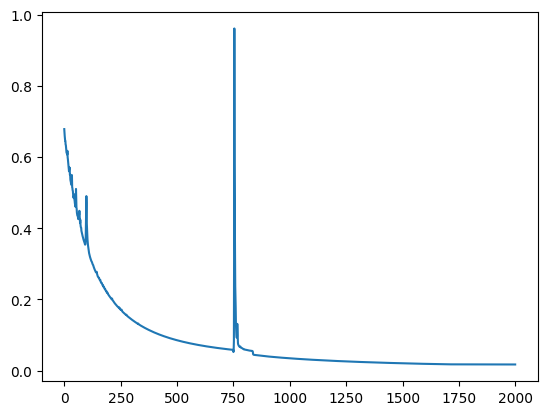

In [ ]:
plt.plot(torch.tensor(losses))

In [ ]:
def predict(model, x):
    for layer in model.layers:
        layer.training = False

    with torch.no_grad():
        y_pred = model(x)
        y_pred = (y_pred > 0.5).float()
    return y_pred

def accuracy(y_pred, y_true):
    return (y_pred == y_true).float().mean()

In [ ]:
predictions_train = predict(model, train_x_orig)
train_accuracy = accuracy(predictions_train, train_y)

predictions_test = predict(model, test_x_orig)
test_accuracy = accuracy(predictions_test, test_y)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")

train accuracy: 1.0
test accuracy: 0.7200000286102295


(array([137.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         72.]),
 array([4.16585593e-04, 9.97059513e-03, 1.95246059e-02, 2.90786158e-02,
        3.86326239e-02, 4.81866337e-02, 5.77406436e-02, 6.72946498e-02,
        7.68486634e-02, 8.64026770e-02, 9.59566832e-02, 1.05510689e-01,
        1.15064703e-01, 1.24618717e-01, 1.34172723e-01, 1.43726736e-01,
        1.53280750e-01, 1.6283

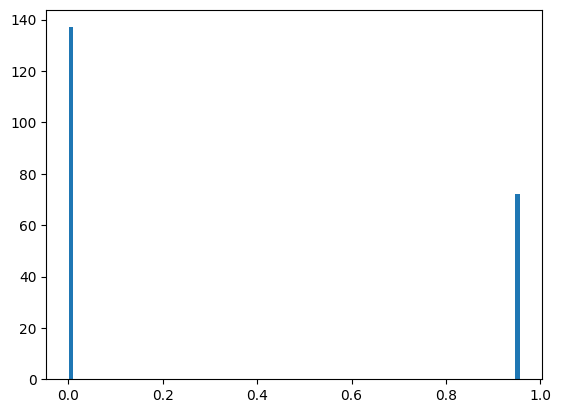

In [ ]:
plt.hist(predictions_train,bins=100)